In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt
from pennylane.templates.layers import StronglyEntanglingLayers

In [2]:
#data = np.loadtxt("sine.txt")
E = np.linspace(0,2,50)
F= np.exp(E*3)
len(F)
E[2]

tensor(0.08163265, requires_grad=True)

In [52]:
data = np.loadtxt("sine.txt")
X = np.array(data[:, 0], requires_grad=False)
Y = np.array(data[:, 1], requires_grad=False)
X[0]

tensor(-0.11268649, requires_grad=False)

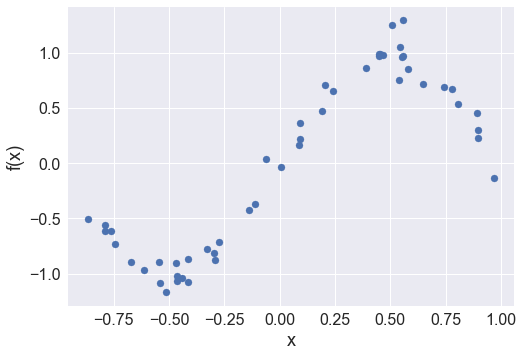

In [51]:
plt.scatter(X,Y)
plt.xlabel("x", fontsize=18)  # helps to increase the size of "X" and "f(X)"
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

In [5]:
nqubits=2

In [6]:
dev=qml.device("default.qubit",wires=nqubits)

In [1]:
'''
The idea of encoding input x is taken from another code and that is not my own.
'''

'\nThe idea of encoding input x is taken from another code and that is not my own.\n'

In [28]:
def init_stateprep(input_x):
    l=input_x
     # U(l)-CNOT-U(l)-CNOT-----U(l)=f(Rz,Ry)
    
    for q in range(nqubits):
        qml.RY(l,wires=q)
        qml.RZ(l,wires=q)
        
    for q in range(nqubits-1):
        qml.CNOT(wires=[q,q+1])
        
    for q in range(nqubits):
        qml.RY(l,wires=q)
        qml.RZ(l,wires=q)
        
    for q in range(nqubits-1):
        qml.CNOT(wires=[q,q+1])
   

In [29]:
def layer(params):
    l=params
    if len(l)!=3*nqubits:
        raise ValueError("The number of parameters should be 3 times the number of qubits/wires")
        
    for q in range(nqubits-1):
        qml.CNOT(wires=[q,q+1])
        
    for q in range(nqubits):
        qml.RX(l[q],wires=q)
        qml.RZ(l[q+nqubits],wires=q)
        qml.RX(l[q+nqubits+nqubits],wires=q)
   

In [30]:
@qml.qnode(dev)
def QNN(params,input_val):
    init_stateprep(input_val)
    
    for l in params:
        layer(l)
        
    measurement_val=[]
    for q in range(nqubits):
        result=qml.expval(qml.PauliZ(q))
        measurement_val.append(result)
        
    return measurement_val
 

In [54]:
QNN(weights,X[1])

tensor([0.90406234, 0.34015427], requires_grad=True)

In [31]:
def betas_matrix(m,y):
    mq=np.array(m) 
    betas= np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(mq),mq )),np.transpose(mq)),y)
    return betas

In [32]:
def betas_model(weights,x,y):
    measure=[]
    for i in range(len(x)):
        m=QNN(weights, x[i])
        measure.append(m)
    mq=measure
    betas=betas_matrix(mq,y)
    return betas

In [33]:
def predictor(weights,x,fz,betas):
    m=QNN(weights, x)
    m=m[0:fz]
    matriz_pr=[]
    for i in range(fz):
        pr=m[i,]*betas[i,]
        matriz_pr.append(pr)
    pred=np.sum(matriz_pr)
    return pred

In [34]:
def square_loss(actual,predictions):
    sq_loss=0
    #loss=0
    for a,y in zip(predictions,actual):
        sq_loss=sq_loss + (a - y)**2
        
    sq_loss=sq_loss/len(predictions)
    
    return sq_loss


In [35]:

def cost(weights,x,y,fz):
    betas=betas_model(weights,x,y)
    predi=[]
    for i in range(len(x)):
        pred=predictor(weights,x[i],fz,betas)
        predi.append(pred)
    predic=predi
    res=square_loss(y, predic)
    return res

In [36]:
def cost2(params,actual,x):
    predictions=[QNN(params,input_val) for input_val in x]
    
    return square_loss(predictions,actual)


In [37]:
fz=2
num_layers=3
weights=0.01*np.random.rand(num_layers,3*nqubits)
print(weights)

[[0.00489583 0.00192291 0.00188506 0.00540249 0.00437327 0.0016536 ]
 [0.00568101 0.00312793 0.00313026 0.00265721 0.00742074 0.00410068]
 [0.00771285 0.00499313 0.00214599 0.00798514 0.00586053 0.00541698]]


In [38]:
print(QNN(weights,0.9))
#QNN.draw()
specs_func = qml.specs(QNN)
specs_func(weights,0.9)

[ 0.21874488 -0.12216545]


{'gate_sizes': defaultdict(int, {1: 26, 2: 5}),
 'gate_types': defaultdict(int, {'RY': 4, 'RZ': 10, 'CNOT': 5, 'RX': 12}),
 'num_operations': 31,
 'num_observables': 2,
 'num_diagonalizing_gates': 0,
 'num_used_wires': 2,
 'depth': 18,
 'num_device_wires': 2,
 'device_name': 'default.qubit.autograd',
 'diff_method': 'backprop'}

In [39]:
cost(weights,Y,X,fz)

tensor(0.2679652, requires_grad=False)

In [40]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

In [41]:
cost_arr=[]
param_arr=[]
for it in range(100):
    weights = opt.step(lambda v: cost(v, X, Y, fz), weights)
    betas=betas_model(weights,X,Y)
    predics =[]
    for i in range(len(X)):
        p=predictor(weights,X[i],fz,betas) 
        predics.append(p)
    print("Iter: {:5d} | Cost: {:0.7f}".format(it + 1, cost(weights, X, Y, fz)))
    cost_arr.append(cost(weights, X, Y, fz))
    param_arr.append(weights)

Iter:     1 | Cost: 0.5849061
Iter:     2 | Cost: 0.5796325
Iter:     3 | Cost: 0.5745131
Iter:     4 | Cost: 0.5692297
Iter:     5 | Cost: 0.5635599
Iter:     6 | Cost: 0.5572956
Iter:     7 | Cost: 0.5502081
Iter:     8 | Cost: 0.5420254
Iter:     9 | Cost: 0.5324096
Iter:    10 | Cost: 0.5209334
Iter:    11 | Cost: 0.5070530
Iter:    12 | Cost: 0.4900835
Iter:    13 | Cost: 0.4691886
Iter:    14 | Cost: 0.4434175
Iter:    15 | Cost: 0.4118542
Iter:    16 | Cost: 0.3739808
Iter:    17 | Cost: 0.3303326
Iter:    18 | Cost: 0.2832964
Iter:    19 | Cost: 0.2373853
Iter:    20 | Cost: 0.1980527
Iter:    21 | Cost: 0.1691712
Iter:    22 | Cost: 0.1511720
Iter:    23 | Cost: 0.1415432
Iter:    24 | Cost: 0.1368043
Iter:    25 | Cost: 0.1340555
Iter:    26 | Cost: 0.1314605
Iter:    27 | Cost: 0.1280908
Iter:    28 | Cost: 0.1236114
Iter:    29 | Cost: 0.1180241
Iter:    30 | Cost: 0.1115006
Iter:    31 | Cost: 0.1042871
Iter:    32 | Cost: 0.0966515
Iter:    33 | Cost: 0.0888552
Iter:    3

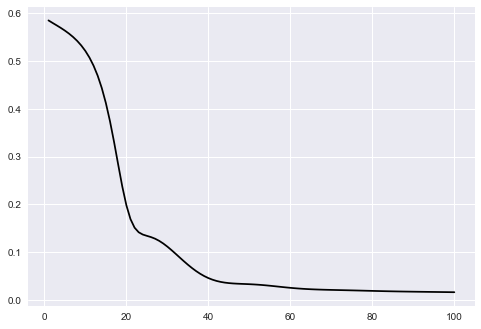

In [42]:
x=np.linspace(1,100,100)
plt.style.use("seaborn")
y=cost_arr
plt.plot(x,y,"black",label="cost values")

In [45]:

p=[]
for i in range(100):
    p.append(param_arr[i].flatten())
param_arr[0].flatten()

tensor([ 1.73355642e-03,  5.08518452e-03, -1.27720905e-03,
         8.56476428e-03,  1.21099496e-03,  4.81587256e-03,
         8.84329019e-03,  6.29020306e-03, -3.20086881e-05,
         5.81948069e-03,  1.05830193e-02,  7.26295609e-03,
         4.55057524e-03,  8.15540430e-03, -1.01627236e-03,
         1.11474064e-02,  2.69825330e-03,  8.57926219e-03], requires_grad=True)

In [46]:
len(p)

100

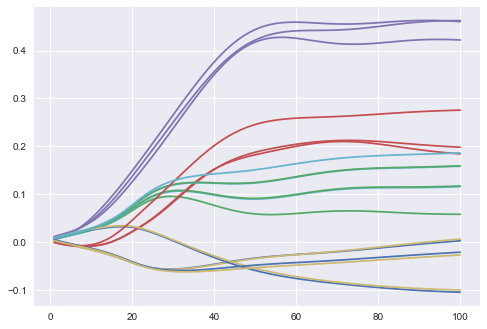

In [47]:
plt.plot(x,p)

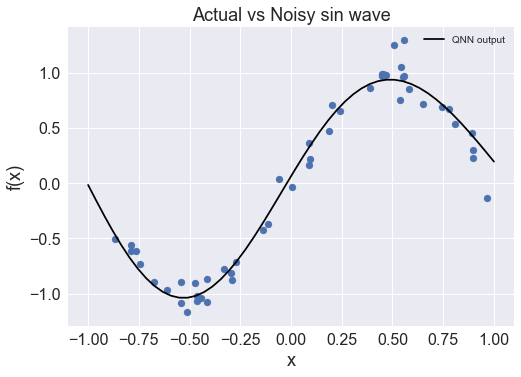

In [50]:
x_pred = np.linspace(-1, 1, 50)
y_pred=[]
for i in range(len(X)):
    new_pred=predictor(weights,x_pred[i],fz,betas) 
    y_pred.append(new_pred)
plt.plot(x_pred,y_pred,"black",label="QNN output")
plt.scatter(X,Y)
plt.xlabel("x", fontsize=18)  # helps to increase the size of "X" and "f(X)"
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)   # helps to increase the size of the values in X and Y axis
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.title("Actual vs Noisy sin wave", fontsize=18)
plt.style.use("seaborn")
plt.legend()
plt.show()

In [97]:
QNN.draw()

' 0: ──RY(0.9)──RZ(0.9)──╭C──RY(0.9)──RZ(0.9)──╭C──╭C──RX(0.00582)──RZ(0.00339)──RX(0.00565)──╭C──RX(0.00998)──RZ(0.00118)──RX(0.00259)──╭C──RX(0.00885)──RZ(0.00975)──RX(4.42e-05)──┤ ⟨Z⟩ \n 1: ──RY(0.9)──RZ(0.9)──╰X──RY(0.9)──RZ(0.9)──╰X──╰X──RX(0.0041)───RZ(0.00295)──RX(0.00435)──╰X──RX(0.00492)──RZ(0.0093)───RX(0.00809)──╰X──RX(0.00245)──RZ(0.00526)──RX(0.00144)───┤ ⟨Z⟩ \n'